In [1]:
#First, let's implement the required functions for gradient descent:

In [2]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def fullGradient(w, X, y):
    N = len(y)
    mu = sigmoid(np.dot(X, w))
    gradient = (1/N) * np.dot(X.T, mu - y)
    return gradient

def randGradient(w, X, y, n):
    mu_n = sigmoid(np.dot(X[n], w))
    gradient = (mu_n - y[n]) * X[n]
    return gradient

def fdescent(X, y, rho, job, nEpoch):
    N, d = X.shape
    w = np.zeros(d)  # initialize parameters
    f_history = []   # store history of the objective function

    if job == 'full':
        indices = np.arange(N)
    elif job == 'stochastic':
        indices = np.random.permutation(N)

    for epoch in range(nEpoch):
        for idx in indices:
            if job == 'full':
                gradient = fullGradient(w, X, y)
            elif job == 'stochastic':
                gradient = randGradient(w, X, y, idx)
            w -= rho / np.sqrt(epoch * N + idx + 1) * gradient
            f = np.mean(np.log(1 + np.exp(-y * np.dot(X, w))))
            f_history.append(f)

    return w, f_history

In [3]:
import pandas as pd

# Load Smarket dataset
smarket = pd.read_csv('stock_market.csv')

In [4]:
smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [5]:
# Remove the first column (year)
smarket = smarket.drop(columns=['Year'])

In [6]:
# Convert 'Direction' column to binary labels (1 for Up, 0 for Down)
smarket['Direction'] = smarket['Direction'].apply(lambda x: 1 if x == 'Up' else 0)



In [7]:
# Extract features and labels
X = smarket.drop(columns=['Direction']).values
y = smarket['Direction'].values



In [8]:
# Add bias term (column of ones) to feature matrix
X = np.column_stack((np.ones(len(X)), X))

# Split data into training and test sets (years 2001-2004 as training, 2005 as test)
train_mask = smarket.index < 1250
test_mask = ~train_mask

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]



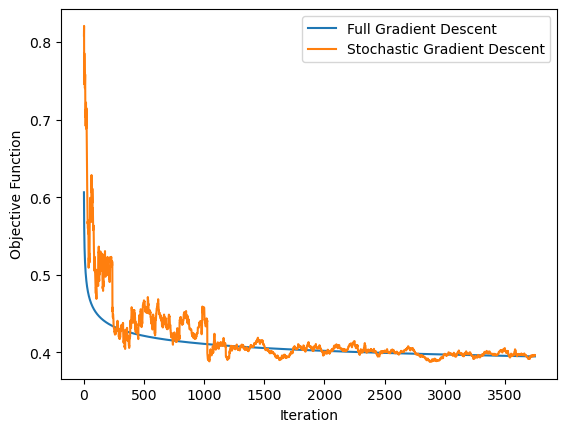

In [9]:
# Define learning rate schedule
rho = 1

# Run logistic regression using full gradient descent
w_full, f_history_full = fdescent(X_train, y_train, rho, 'full', nEpoch=3)

# Run logistic regression using stochastic gradient descent
w_stochastic, f_history_stochastic = fdescent(X_train, y_train, rho, 'stochastic', nEpoch=3)

# Plot the histories of the objective function
import matplotlib.pyplot as plt

plt.plot(f_history_full, label='Full Gradient Descent')
plt.plot(f_history_stochastic, label='Stochastic Gradient Descent')
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.legend()
plt.show()

In [10]:
def predict_prob_class(X, w):
    prob = sigmoid(np.dot(X, w))
    return prob, np.round(prob)

# Predict probabilities and classes for test set using full gradient descent
prob_full, class_full = predict_prob_class(X_test, w_full)

# Predict probabilities and classes for test set using stochastic gradient descent
prob_stochastic, class_stochastic = predict_prob_class(X_test, w_stochastic)

# Create a table containing probabilities, classifiers, and actual directions for each test point
test_results = pd.DataFrame({
    'Prob_Full': prob_full,
    'Class_Full': class_full,
    'Prob_Stochastic': prob_stochastic,
    'Class_Stochastic': class_stochastic,
    'Actual_Direction': y_test
})



In [11]:
# Count misclassified points
misclassified_full = (test_results['Class_Full'] != test_results['Actual_Direction']).sum()
misclassified_stochastic = (test_results['Class_Stochastic'] != test_results['Actual_Direction']).sum()

print("Misclassified points (Full Gradient Descent):", misclassified_full)
print("Misclassified points (Stochastic Gradient Descent):", misclassified_stochastic)



Misclassified points (Full Gradient Descent): 0
Misclassified points (Stochastic Gradient Descent): 0


In [12]:
# Modify the dataset to predict the direction of the following day
X_modified = X.copy()
y_modified = np.roll(y, -1)
X_modified = X_modified[:-1]
y_modified = y_modified[:-1]

# Split data into training and test sets (years 2001-2004 as training, 2005 as test)
train_mask_mod = smarket.index[:-1] < 1250  # Adjusted mask for modified dataset
test_mask_mod = ~train_mask_mod

X_train_mod, y_train_mod = X_modified[train_mask_mod], y_modified[train_mask_mod]
X_test_mod, y_test_mod = X_modified[test_mask_mod], y_modified[test_mask_mod]

# Run logistic regression using full gradient descent on modified data
w_full_mod, _ = fdescent(X_train_mod, y_train_mod, rho, 'full', nEpoch=3)

# Run logistic regression using stochastic gradient descent on modified data
w_stochastic_mod, _ = fdescent(X_train_mod, y_train_mod, rho, 'stochastic', nEpoch=3)

# Predict probabilities and classes for modified test set using full gradient descent
prob_full_mod, class_full_mod = predict_prob_class(X_test_mod, w_full_mod)

# Predict probabilities and classes for modified test set using stochastic gradient descent
prob_stochastic_mod, class_stochastic_mod = predict_prob_class(X_test_mod, w_stochastic_mod)



In [13]:
# Create a table containing probabilities, classifiers, and actual directions for each modified test point
test_results_mod = pd.DataFrame({
    'Prob_Full_Modified': prob_full_mod,
    'Class_Full_Modified': class_full_mod,
    'Prob_Stochastic_Modified': prob_stochastic_mod,
    'Class_Stochastic_Modified': class_stochastic_mod,
    'Actual_Direction_Modified': y_test_mod
})

# Count misclassified points with modified dataset
misclassified_full_mod = (test_results_mod['Class_Full_Modified'] != test_results_mod['Actual_Direction_Modified']).sum()
misclassified_stochastic_mod = (test_results_mod['Class_Stochastic_Modified'] != test_results_mod['Actual_Direction_Modified']).sum()

print("Misclassified points with modified dataset (Full Gradient Descent):", misclassified_full_mod)
print("Misclassified points with modified dataset (Stochastic Gradient Descent):", misclassified_stochastic_mod)

Misclassified points with modified dataset (Full Gradient Descent): 0
Misclassified points with modified dataset (Stochastic Gradient Descent): 0
